# Algoritmos por bloques

El propósito de estos apuntes es mostrar como puede disminuir el tiempo de ejecución de una función al realizar una lectura por bloques de los elementos en memoria. En particular, el estudio estará centrado en la operación transpuesta de una matriz.

## Dependencias

In [1]:
import numpy
import ctypes
import time
from statistics import mean
from utilities import filtro_mediana
import matplotlib.pyplot as plt
from numpy import asarray

# Implementación en C de ambas formas

In [2]:
%%file transposelib.c
void transposeclassic(double *A, double *AT, int N)
{
    for(int i = 0; i < N; i++){
        for(int j = 0; j < N; j++){
            AT[j+i*N] = A[i+j*N];
        }
    }   
}

void transposeblock(double *A, double *AT, int N, int block)
{
    for (int i = 0; i < N; i += block) {
        for (int j = 0; j < N; j += block) {
            for (int k = i; k < i + block; ++k) {
                for (int l = j; l < j + block; ++l) {
                    AT[k + l*N] = A[l + k*N];
                }
            }
        }
    }   
}

Writing transposelib.c


In [3]:
! gcc -c transposelib.c -o transposelib.o
! gcc -shared transposelib.o -o transposelib.so

## Enlace a Python

In [4]:
def ctypes_transposelib():
    # ruta de la shared library
    transposelib = ctypes.CDLL('./transposelib.so')
    
    # tipo de los argumentos de la forma sin bloques
    transposelib.transposeclassic.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.double),
        numpy.ctypeslib.ndpointer(dtype=numpy.double),
        ctypes.c_int
    ]
    
    # tipo de los argumentos de la forma con bloques
    transposelib.transposeblock.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.double),
        numpy.ctypeslib.ndpointer(dtype=numpy.double),
        ctypes.c_int,
        ctypes.c_int
    ]
    
    # se devuelve las funciones configuradas
    return transposelib.transposeclassic, transposelib.transposeblock

Instancias de las funciones

In [5]:
transposeclassic, transposeblock = ctypes_transposelib()

## Prueba numérica

In [6]:
n = 2048
b = 2
A = numpy.random.rand(n,n)
Y = A.flatten()
At1 = numpy.zeros_like(A.flatten())
At2 = numpy.zeros_like(A.flatten())

In [7]:
transposeclassic(Y,At1,n)
# error relativo
numpy.linalg.norm(numpy.transpose(A).flatten()-At1)/numpy.linalg.norm(numpy.transpose(A).flatten())

0.0

In [8]:
transposeblock(Y,At2,n,b)
# error relativo
numpy.linalg.norm(numpy.transpose(A).flatten()-At2)/numpy.linalg.norm(numpy.transpose(A).flatten())

0.0

## Medición de tiempos

In [9]:
ns = 2**numpy.arange(5,13)
veces = range(40)

In [10]:
ltb2 = []
ltb4 = []
ltb8 = []
lt = []
for n in ns:
    ltb2i = []
    ltb4i = []
    ltb8i = []
    lti = []
    for _ in veces:
        # entradas
        A = numpy.random.rand(n,n)
        Y = A.flatten()
        # referencia
        Atn = numpy.transpose(A)
        Ytn = Atn.flatten()
        
        # para la forma sin bloques
        At = numpy.zeros_like(Ytn)
        # para bloque 2
        At2 = numpy.zeros_like(Ytn)
        # para bloque 4 
        At4 = numpy.zeros_like(Ytn)
        # para bloque 8
        At8 = numpy.zeros_like(Ytn)

        # 2
        tic = time.time()
        transposeblock(Y,At2,n,2)
        toc = time.time()
        ltb2i.append(toc-tic)
        
        # 4
        tic = time.time()
        transposeblock(Y,At4,n,4)
        toc = time.time()
        ltb4i.append(toc-tic)
        
        # 8
        tic = time.time()
        transposeblock(Y,At8,n,8)
        toc = time.time()
        ltb8i.append(toc-tic)
        
        # sin bloques
        tic = time.time()
        transposeclassic(Y,At,n)
        toc = time.time()
        lti.append(toc-tic)
    
    ltb2.append(mean(filtro_mediana(ltb2i,11)))
    ltb4.append(mean(filtro_mediana(ltb4i,11)))
    ltb8.append(mean(filtro_mediana(ltb8i,11)))
    lt.append(mean(filtro_mediana(lti,11)))

## Presentación de resultados

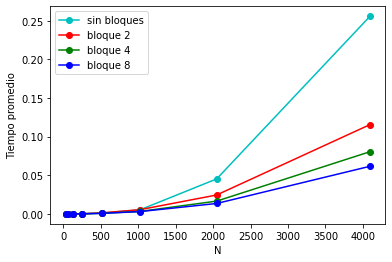

In [11]:
plt.plot(ns,lt,'-co',label='sin bloques')
plt.plot(ns,ltb2,'-ro',label='bloque 2')
plt.plot(ns,ltb4,'-go',label='bloque 4')
plt.plot(ns,ltb8,'-bo',label='bloque 8')
plt.xlabel('N')
plt.ylabel('Tiempo promedio')
plt.legend()

Para un bloque de tamaño 2 salió más lento que la forma sin bloques :'v, y recién mejoró su rendimiento luego de `N=1024`. A pesar de eso, se empleará la forma sin bloques como referencia para calcular el _speedup_.

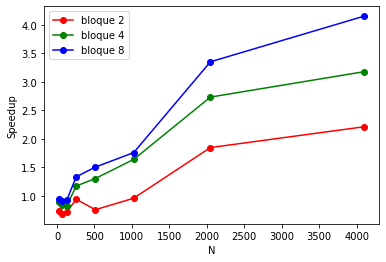

In [12]:
plt.plot(ns,asarray(lt)/asarray(ltb2),'-ro',label='bloque 2')
plt.plot(ns,asarray(lt)/asarray(ltb4),'-go',label='bloque 4')
plt.plot(ns,asarray(lt)/asarray(ltb8),'-bo',label='bloque 8')
plt.xlabel('N')
plt.ylabel('Speedup')
plt.legend()

Para un tamaño de bloque 4 y 8 recién se observa ganancia a partir de `N=256`

In [13]:
! rm *.o
! rm *.so
! rm *.c